# Sentinel-2A Orbit Evolution Analysis

The actual orbit information from the satellites tell a lot about how a satellite is operated (and occasionally how they are out of control). The main source of information is the [Space-Track website](https://www.space-track.org/), where we can download the measured orbit data. For this analysis we are going to use the data for the [European Space Agency's Sentinel-2A](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2) optical earth observation satellite. The orbit data is used and distributed with this example with the explicit permission from [18th Space Control Squadron](https://en.wikipedia.org/wiki/18th_Space_Control_Squadron) and further distribution for any other purpose can only be with their permission only.

Sentinel-2A is in a [Sun-Synchronous Orbit](https://en.wikipedia.org/wiki/Sun-synchronous_orbit), where the orbital plane of the satellite keeps a fixed (or changing around a mean) orientation with respect to the sun. This enables the satellite to keep a predictable sun-Earth-satellite orientation, increasing the data production quality. Some satellites also keep the orbit in such a way that the satellite [ground-track](https://en.wikipedia.org/wiki/Ground_track) repeats a certain pattern. Some are even in [Frozen Orbits](https://en.wikipedia.org/wiki/Frozen_orbit), where the eccentricity vector (or argument of perigee value is fixed). This enables the satellite to have a fixed (and known) altitude over a given latitude. All of these properties enable the satellite orbit (hence observation conditions as well as mission planning) to be predictable over the course of the mission lifetime. This is true for Sentinel-2A.

This analysis will show how certain orbital parameters are maintained over the lifetime of the satellite. The analysis below can be easily repeated with other satellites, just by replacing the orbit file.

The first step loads the file from the local path, skipping some initial orbit determination results so that the results are more reliable.

In [50]:
from pathlib import Path
from astropy import units as u
from satmad.propagation.tle_storage import TleStorage
from satmad.plots.plotstyling import format_axis_with_grid

sat_name = "Sentinel-2A"
sat_number = 40697

# number of initial data points to skip
skip_from_begin = 20

# Figures file output flag
output_figs_to_file = False

file_path = Path("data", "s2a", "s2a_40697.txt")

# load file
tle_storage = TleStorage.from_path(file_path).to_tle_timeseries(sat_number)

print(f"Initial date on TLE list: {tle_storage.tle_list[0].epoch.isot}")
print(f"Final date on TLE list: {tle_storage.tle_list[-1].epoch.isot}")
print(f"Number of elements in TLE list: {len(tle_storage.tle_list)}")
print(f"Average time between TLEs: {(tle_storage.tle_list[-1].epoch - tle_storage.tle_list[0].epoch).to(u.day) / len(tle_storage.tle_list)}")

Initial date on TLE list: 2015-06-23T03:50:23.385
Final date on TLE list: 2021-08-17T03:18:09.706
Number of elements in TLE list: 6662
Average time between TLEs: 0.33728274431224076 d


A few useful results can be drawn by checking the simple properties of the data. In more than 6 years, there are more than 6600 orbit points, averaging 3 orbit points per day.

The next step is to plot the overall semimajor axis evolution. This shows that the semimajor axis is kept within a very narrow range - only +/- 20 metres. Such a tight control is required to prevent a significant deviation from the frozen orbit conditions.

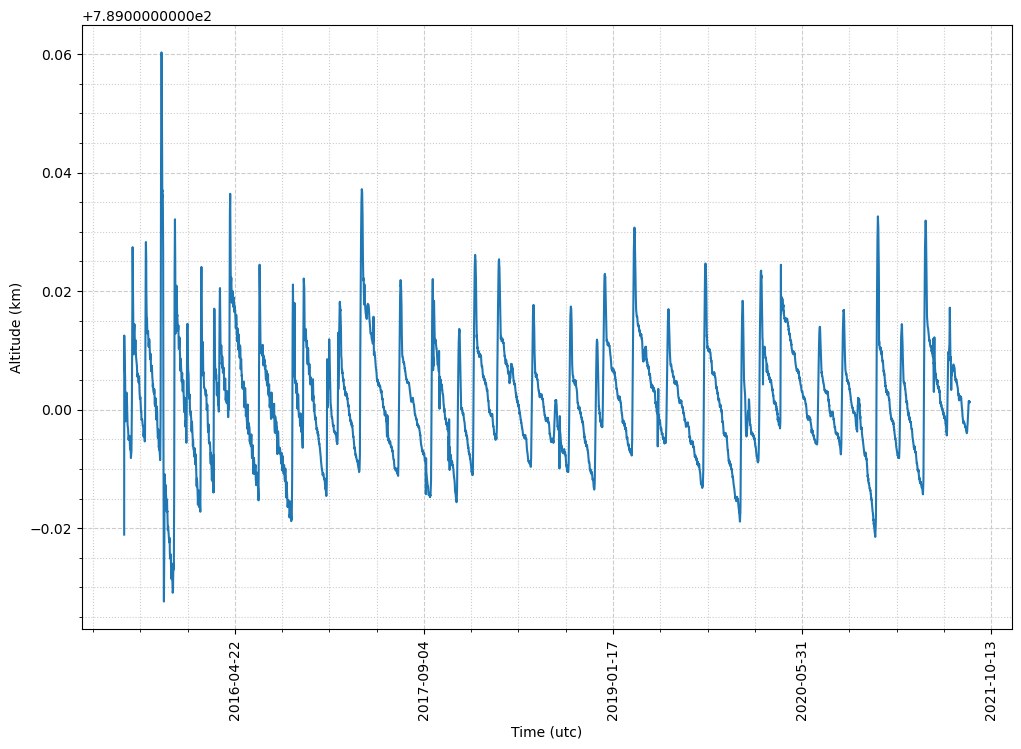

In [51]:
from astropy.time import Time
from astropy.visualization import time_support, quantity_support
from matplotlib import pyplot as plt

from satmad.core.celestial_bodies_lib import EARTH

quantity_support()
time_support(format='isot')

time_list = Time([tle.epoch.to_value("jd") for tle in tle_storage.tle_list][skip_from_begin:], format="jd")
alt_list = [tle.sm_axis.to_value(u.km) - EARTH.ellipsoid.re.to_value(u.km) for tle in tle_storage.tle_list][skip_from_begin:] * u.km

fig0, ax0_1 = plt.subplots(figsize=(12,8), dpi=100)

# Format axes
format_axis_with_grid(ax0_1, y_label="Altitude (km)", x_rotation=True)

ax0_1.plot(time_list, alt_list)

if output_figs_to_file:
    fig0.savefig("fig0.jpg", format="jpg", bbox_inches="tight")

plt.show()

This tight control becomes evident when the semimajor axis and inclination evolution are plotted together. The linearly decreasing semimajor axis (due to atmospheric drag), and the similarly decreasing inclination (due to the gravitational pull of the Sun) are corrected regularly. Semimajor axis corrections take place roughly every two months, whereas inclination corrections take place roughly every 4 months.

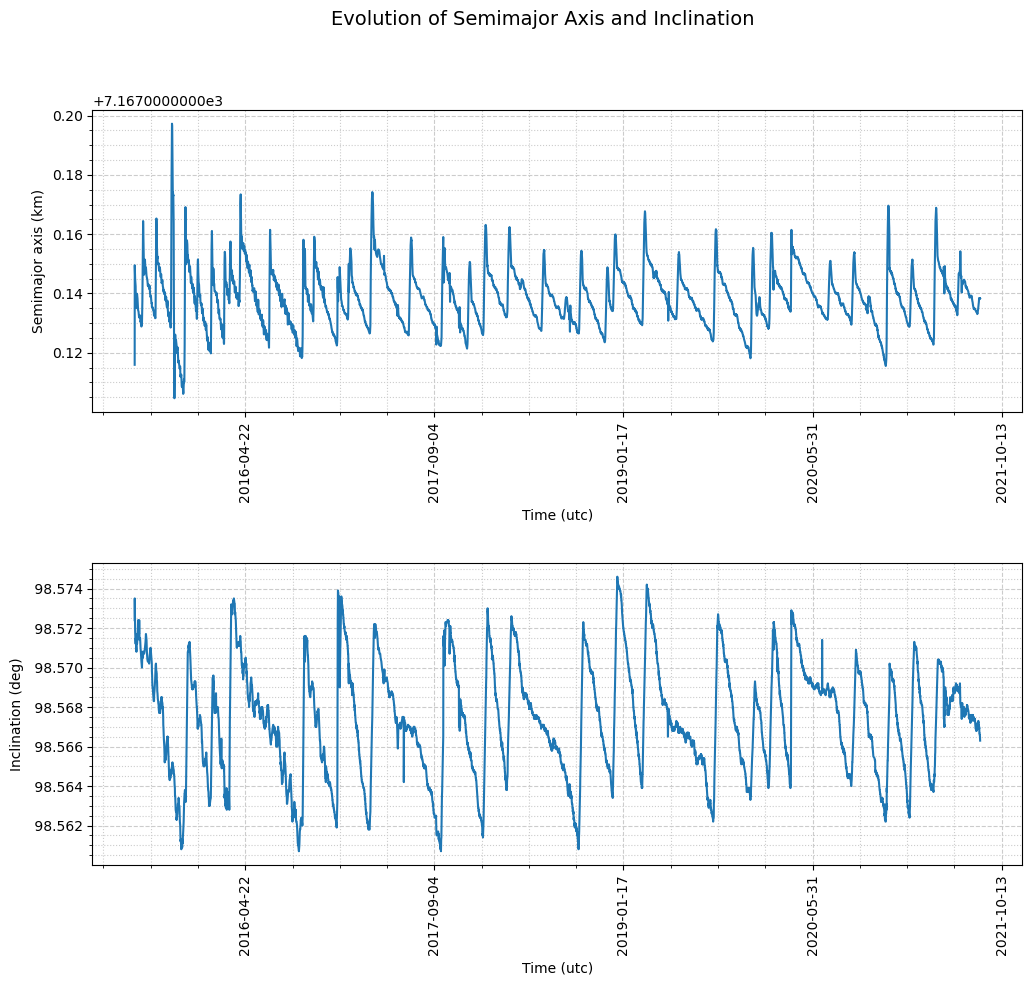

In [52]:
from matplotlib.ticker import FormatStrFormatter

incl_list = [tle.inclination.to_value(u.deg) for tle in tle_storage.tle_list][skip_from_begin:] * u.deg
sma_list = [tle.sm_axis.to_value(u.km) for tle in tle_storage.tle_list][skip_from_begin:] * u.km

fig1, ax1 = plt.subplots(nrows=2,ncols=1,figsize=(12,10), dpi=100)

fig1.suptitle("Evolution of Semimajor Axis and Inclination", fontsize = 14)

fig1.subplots_adjust(hspace=0.5)

# Format axes
ax1[0] = format_axis_with_grid(ax1[0], y_label="Semimajor axis (km)",  x_rotation=True)
ax1[0].plot(time_list, sma_list)

# Format axes
ax1[1] = format_axis_with_grid(ax1[1], y_label="Inclination (deg)", x_rotation=True)
ax1[1].yaxis.set_major_formatter(FormatStrFormatter("% 3.3f"))
ax1[1].plot(time_list, incl_list)

if output_figs_to_file:
    fig1.savefig("fig1.jpg", format="jpg", bbox_inches="tight")

plt.show()

A similar conclusion can be drawn from the eccentricity plot. Frozen orbit conditions require a tight control of the eccentricity and this is exactly what is happening. Semimajor axis firings are used to control eccentricity as well.

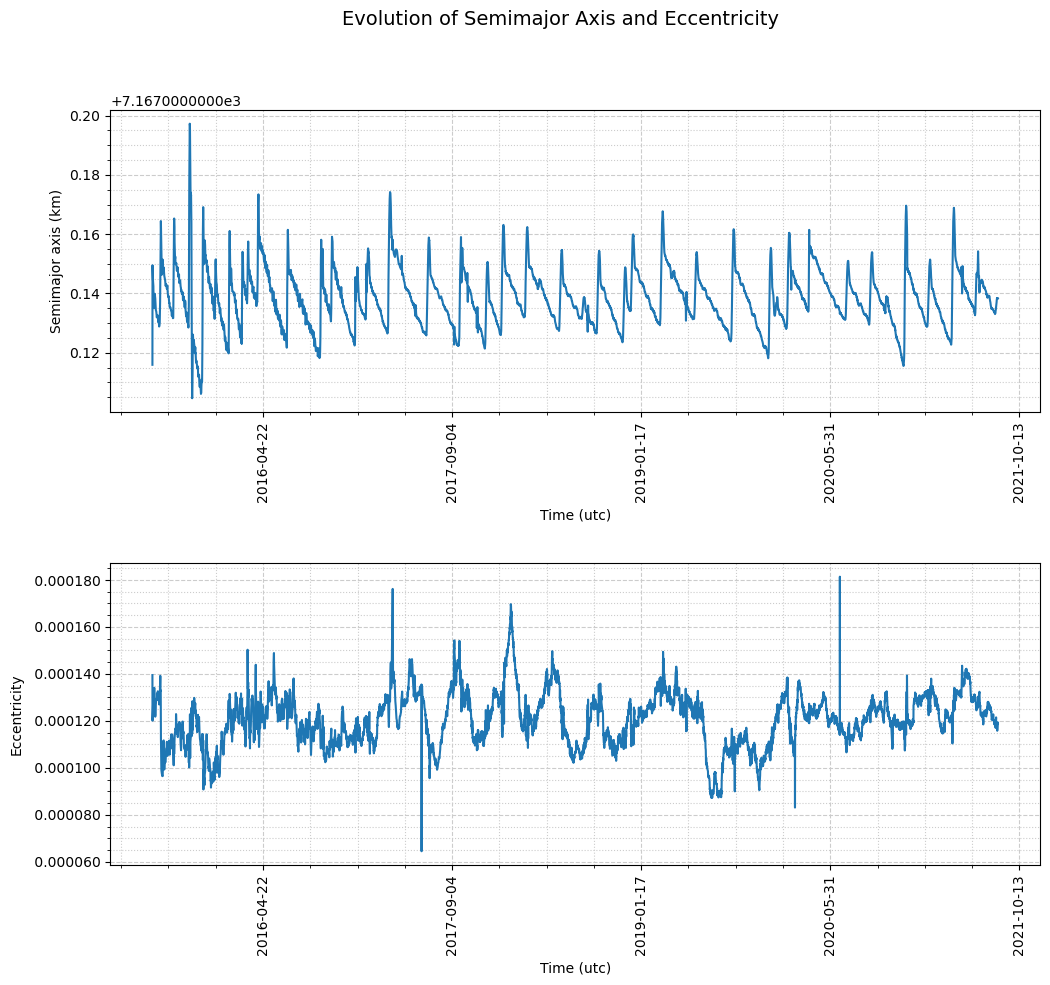

In [56]:
ecc_list = [tle.eccentricity for tle in tle_storage.tle_list][skip_from_begin:]

fig2, ax2 = plt.subplots(nrows=2,ncols=1,figsize=(12,10), dpi=100)

fig2.suptitle("Evolution of Semimajor Axis and Eccentricity", fontsize = 14)

fig2.subplots_adjust(hspace=0.5)

# Format axes
ax2[0] = format_axis_with_grid(ax2[0], y_label="Semimajor axis (km)", x_rotation=True)
ax2[0].plot(time_list, sma_list)

# Change major ticks (180 days, 0.0005 ecc)
ax2[1] = format_axis_with_grid(ax2[1], y_label="Eccentricity", x_rotation=True)
ax2[1].yaxis.set_major_formatter(FormatStrFormatter("% 4.6f"))
ax2[1].plot(time_list, ecc_list)

if output_figs_to_file:
    fig2.savefig("fig2.jpg", format="jpg", bbox_inches="tight")

plt.show()

We can focus on a single TLE to check the sun-synchronous properties of the orbit. For this we take the TLE at position 4000.

Unlike ideal (and unrealistic) two-body dynamics, orbital planes of the satellites rotate due to the primary term of the oblateness of the Earth, or $J_2$ in orbital mechanics parlance. Sun-synchronous orbits are designed to fix that rotation rate to one full rotation per year i.e, this rotation has a period of exactly one year. This keeps the orientation of the orbital plane (ideally) at a fixed angle to the Sun. Therefore, the rate of rotation of the orbital plane (or the node) should be equal to:

$$ \frac{360 \deg}{365.25 \text{ days}} = 0.9856262833675564 \deg / \text{day}$$

Coming back to the orbit of Sentinel-2A, once the orbital elements are read, it is possible to query the node rotation rate using the command `node_rotation_rate()`.

In [54]:
# take the TLE at position 4000
tle = tle_storage.tle_list[4000]

print(f"TLE date: {tle.epoch.isot}")
print(f"Sentinel-2A semimajor axis: {tle.sm_axis}")
print(f"Sentinel-2A true node rotation rate: {tle.node_rotation_rate}")

TLE date: 2019-09-19T07:19:47.992
Sentinel-2A semimajor axis: 7167.161279973463 km
Sentinel-2A true node rotation rate: 0.9870423570757711 deg / d


As expected, the node rotation rate of Sentinel-2A is very close to (but not exactly equal to) the ideal node rotation rate. In reality, the node rotation rate depends on other forces (like drag and other geopotential terms) and Sentinel-2 orbit is maintained with high accuracy, executing orbit maintenance manoeuvres periodically.

It should also be emphasised the TLE orbit parameters are not the high precision values supplied by ESA, but are the measurements from the US Space Surveillance Network and distributed by the [18 SPCS](https://www.space-track.org). Therefore, the mathematical models and the orbit determination precision all play a role in matching the values derived from the simplified analytical models presented here (and the orbital mechanics textbooks).


The next step is to check the frozen orbit conditions. Orbit theory suggests that, for frozen orbit, the following conditions should apply:

$$ \text{eccentricity} = -\frac{J_3 R_E \sin{i} }{2 J_2 a} $$
$$ \text{argument of perigee} = \omega =  90 \deg $$

We can easily check this with Sentinel-2A:

In [55]:
import numpy as np

a = tle.sm_axis
e = tle.eccentricity
i = tle.inclination
j2 = 0.001082616
j3 = -0.00000253881
r_e = 6378.135 * u.km

print(f"ideal eccentricity : {-(j3 * r_e * np.sin(i)) / (2 * j2 * a)}" )
print(f"true eccentricity  : {tle.eccentricity}")
print(f"true arg of perigee : {tle.arg_perigee.to(u.deg)}")


ideal eccentricity : 0.0010318033893208668
true eccentricity  : 0.0001103
true arg of perigee : 84.7946 deg


Once again, the results are *close enough*, but not exactly the same. The same caveats apply as before.
